In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import AdamW
from sklearn.utils.class_weight import compute_class_weight
import numpy as np, os
import matplotlib.pyplot as plt

In [3]:
# Rutas de las carpetas de imagenes para entrenamiento y testing
TRAIN_DIR = "/content/drive/MyDrive/Datasets/ISIC 2024 Dataset/ISIC_2024_Resize224/train"
TEST_DIR = "/content/drive/MyDrive/Datasets/ISIC 2024 Dataset/ISIC_2024_Resize224/test"

IMG_SIZE = (224, 224)   # Tamaño de la imagen
BATCH_SIZE = 32         # Tamaño del batch
EPOCHS = 50             # Cantidad de épocas

In [4]:
# Etapa de carga del dataset

# Dataset de entrenamiento
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,    # Tamaño de imagen, que luego espera EfficientNet
    batch_size=BATCH_SIZE,  # Tamaño del batch que entrena
    label_mode='binary'
)

# Dataset de validación
val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,    # Tamaño de imagen, que luego espera EfficientNet
    batch_size=BATCH_SIZE,  # Tamaño del batch que entrena
    label_mode='binary'
)

# Dataset de testing
test_data = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,    # Tamaño de imagen, que luego espera EfficientNet
    batch_size=BATCH_SIZE,  # Tamaño del batch que entrena
    label_mode='binary',
    shuffle=False
)

Found 12578 files belonging to 2 classes.
Using 10063 files for training.
Found 12578 files belonging to 2 classes.
Using 2515 files for validation.
Found 2000 files belonging to 2 classes.


In [5]:
# Optimización del pipeline de datos con prefetching
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds  = test_data.prefetch(tf.data.AUTOTUNE)

In [6]:
# Calculamos los pesos de cada clase
# Chequeamos clases y cantidad de imagenes en cada una
classes = sorted(os.listdir(TRAIN_DIR))
counts = [len(os.listdir(os.path.join(TRAIN_DIR, c))) for c in classes]

# Calculamos los pesos balanceados
class_weights_arr = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(classes)),
    y=np.concatenate([[i] * counts[i] for i in range(len(classes))])
)

# Lo convertimos en un diccionario, luego se usara en el entrenamiento
class_weights = dict(enumerate(class_weights_arr))
print("Clases encontradas:", classes)
print("Pesos calculados para las clases:", class_weights)


Clases encontradas: ['Benign', 'Malignant']
Pesos calculados para las clases: {0: np.float64(1.0), 1: np.float64(1.0)}


In [7]:
# Etapa de construccion del modelo

input_layer = tf.keras.Input(shape=(224, 224, 3))   # Capa de entrada, 224 x 224 y RGB (Tercer parametro)

# Data augmentation para que no se sobreajuste o generalice durante el entrenamiento
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.10),
    layers.RandomZoom(0.10),
])(input_layer) # Aplicamos sobre la entrada

# Preprocesado para EfficientNet
preprocess_input = tf.keras.applications.efficientnet.preprocess_input(data_augmentation)

# Carga de EfficientNet
base_model = EfficientNetB0(
    include_top=False,
    input_tensor=preprocess_input,
    weights="imagenet"
)

base_model.trainable = False    # Congelamos el modelo base

global_average_layer = layers.GlobalAveragePooling2D()(base_model.output)
normalization_layer = layers.BatchNormalization()(global_average_layer)
dropout_layer = layers.Dropout(0.3)(normalization_layer)
normalization_layer = layers.BatchNormalization()(dropout_layer)

prediction_layer = layers.Dense(1, activation="sigmoid")(normalization_layer)   # Salida binaria

model = models.Model(inputs=input_layer, outputs=prediction_layer)


In [8]:
# Compilamos el modelo con un optimizador AdamW (Con weight decay)

model.compile(
    optimizer=AdamW(learning_rate=0.0003, weight_decay=0.00001),
    loss="binary_crossentropy",
    metrics=["accuracy", AUC(name="auc")]
)

# Resumen del modelo para ver las capas, como entran y como salen
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 4,061,092 (15.49 MB)

 Trainable params: 6,401 (25.00 KB)

 Non-trainable params: 4,054,691 (15.47 MB)

In [9]:
# EarlyStopping con monitoreo de val_loss
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

# ReduceLROnPlateau para jsutar la tasa de aprendizaje cuando la perdida no mejora
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    min_lr=0.0000001
)

In [10]:
# Inicio de entrenamiento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 110s 281ms/step - accuracy: 0.6771 - auc: 0.7439 - loss: 0.6203 - val_accuracy: 0.8469 - val_auc: 0.9229 - val_loss: 0.3595 - learning_rate: 3.0000e-04
Epoch 2/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 44s 138ms/step - accuracy: 0.8208 - auc: 0.9003 - loss: 0.4050 - val_accuracy: 0.8696 - val_auc: 0.9368 - val_loss: 0.3231 - learning_rate: 3.0000e-04
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - accuracy: 0.8402 - auc: 0.9168 - loss: 0.3687 - val_accuracy: 0.8704 - val_auc: 0.9424 - val_loss: 0.3074 - learning_rate: 3.0000e-04
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - accuracy: 0.8521 - auc: 0.9266 - loss: 0.3464 - val_accuracy: 0.8740 - val_auc: 0.9452 - val_loss: 0.3019 - learning_rate: 3.0000e-04
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - accuracy: 0.8606 - auc: 0.9317 - loss: 0.3343 - val_accuracy: 0.8759 - val_auc: 0.9477 - val_loss: 0.2953 - learning_rate: 3.0000e-04
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 42s 

In [11]:
# Guardamos modelo entrenado (Sin fine-tuning)
save_path =  "/content/drive/MyDrive/skin-cancer/saved_models/modelo_benigno_maligno_v9.keras"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
model.save(save_path)
print(f" Modelo guardado correctamente en: {save_path}")

 Modelo guardado correctamente en: /content/drive/MyDrive/skin-cancer/saved_models/modelo_benigno_maligno_v9.keras


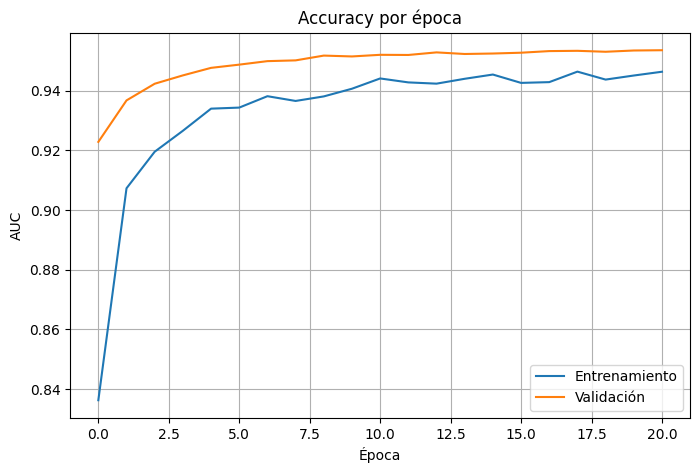

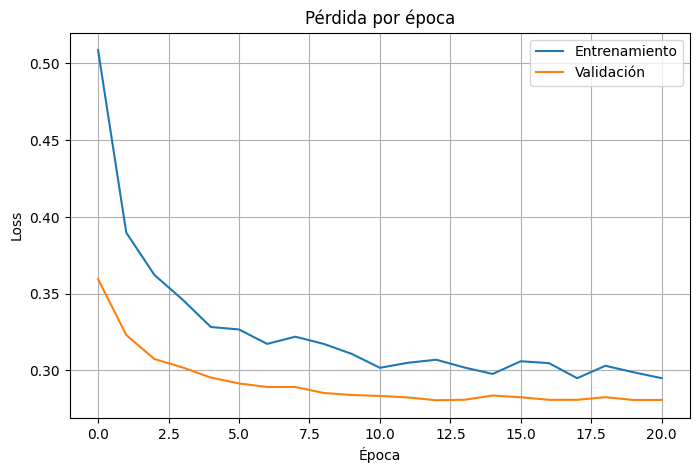

In [12]:
# Grafica de AUC del entrenamiento
plt.figure(figsize=(8,5))
plt.plot(history.history['auc'], label='Entrenamiento')
plt.plot(history.history['val_auc'], label='Validación')
plt.title("Accuracy por época")
plt.xlabel("Época")
plt.ylabel("AUC")
plt.legend()
plt.grid(True)
plt.show()

# Grafica de loss del entrenamiento
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Etapa de fine-tuning
base_model.trainable = True # Permitimos a EfficientNet que entrene

fine_tune_at = int(len(base_model.layers) * 0.60)   # Capas que se van a entrenar

# Congelamos las capas
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=AdamW(learning_rate=0.00001, weight_decay=0.000001),
    loss="binary_crossentropy",
    metrics=["accuracy", AUC(name="auc")]
)

In [14]:
# Entrenamiento del modelo con fine-tuning
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.3, min_lr=0.0000001)
    ],
    verbose=1
)
print("Fine-Tuning completado.")

Epoch 1/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 78s 176ms/step - accuracy: 0.8063 - auc: 0.8896 - loss: 0.4184 - val_accuracy: 0.8632 - val_auc: 0.9435 - val_loss: 0.3099 - learning_rate: 1.0000e-05
Epoch 2/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 53s 167ms/step - accuracy: 0.8542 - auc: 0.9292 - loss: 0.3407 - val_accuracy: 0.8724 - val_auc: 0.9483 - val_loss: 0.2952 - learning_rate: 1.0000e-05
Epoch 3/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 53s 168ms/step - accuracy: 0.8651 - auc: 0.9372 - loss: 0.3238 - val_accuracy: 0.8763 - val_auc: 0.9524 - val_loss: 0.2840 - learning_rate: 1.0000e-05
Epoch 4/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 52s 166ms/step - accuracy: 0.8704 - auc: 0.9404 - loss: 0.3162 - val_accuracy: 0.8827 - val_auc: 0.9552 - val_loss: 0.2742 - learning_rate: 1.0000e-05
Epoch 5/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 52s 165ms/step - accuracy: 0.8808 - auc: 0.9474 - loss: 0.2958 - val_accuracy: 0.8851 - val_auc: 0.9578 - val_loss: 0.2659 - learning_rate: 1.0000e-05
Epoch 6/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 55s 1

In [15]:
# Guardamos el modelo refinado
save_path_ft =  "/content/drive/MyDrive/skin-cancer/saved_models/modelo_benigno_maligno_ft_v9.keras"
os.makedirs(os.path.dirname(save_path_ft), exist_ok=True)
model.save(save_path_ft)
print(f" Modelo afinado guardado correctamente en: {save_path_ft}")

 Modelo afinado guardado correctamente en: /content/drive/MyDrive/skin-cancer/saved_models/modelo_benigno_maligno_ft_v9.keras



Gráficos del Fine-Tuning:


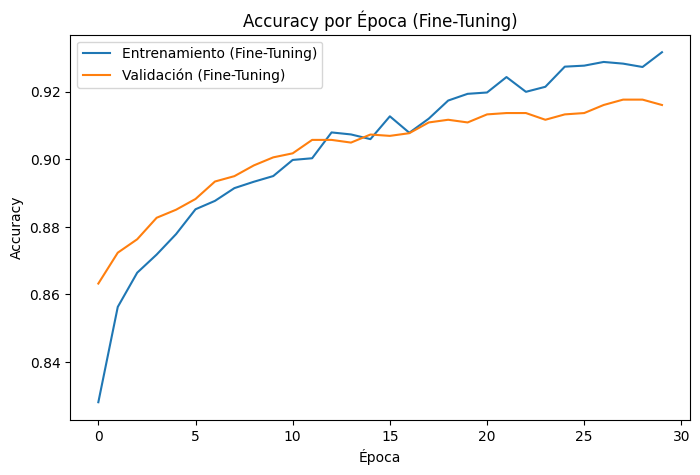

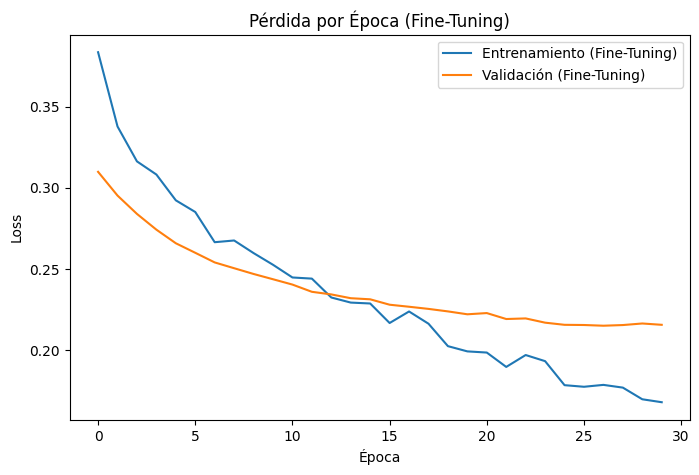

In [16]:
print("\nGráficos del Fine-Tuning:")

# Gráfico de Precisión (Fine-Tuning)
plt.figure(figsize=(8,5))
plt.plot(history_ft.history['accuracy'], label='Entrenamiento (Fine-Tuning)')
plt.plot(history_ft.history['val_accuracy'], label='Validación (Fine-Tuning)')
plt.title("Accuracy por Época (Fine-Tuning)")
plt.xlabel(f"Época")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Gráfico de Pérdida (Fine-Tuning)
plt.figure(figsize=(8,5))
plt.plot(history_ft.history['loss'], label='Entrenamiento (Fine-Tuning)')
plt.plot(history_ft.history['val_loss'], label='Validación (Fine-Tuning)')
plt.title("Pérdida por Época (Fine-Tuning)")
plt.xlabel(f"Época")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
print("\nEvaluando el modelo en el conjunto de prueba:")

results = model.evaluate(test_ds, verbose=1)

print(f"\nResultado Final:")
print(f"  - Pérdida (Loss) en prueba: {results[0]:.4f}")
print(f"  - Precisión (Accuracy) en prueba: {results[1]:.4f}")
print(f"  - AUC: {results[2]:.4f}")


Evaluando el modelo en el conjunto de prueba:
63/63 ━━━━━━━━━━━━━━━━━━━━ 307s 5s/step - accuracy: 0.9345 - auc: 0.5080 - loss: 0.1556

Resultado Final:
  - Pérdida (Loss) en prueba: 0.1951
  - Precisión (Accuracy) en prueba: 0.9145
  - AUC: 0.9780
